# Warmstart Optuna (IonQ)

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))

In [2]:
import optuna
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer, CobylaOptimizer
from qiskit.algorithms import QAOA

from shared.graph_helper import *
from shared.QiskitMaxcut import *
from ionq.ionq_parameters import *

%matplotlib inline

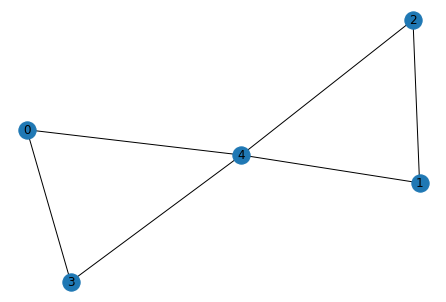

In [3]:
# ---- Define graph and MaxCut ----
graph = generate_butterfly_graph(with_weights=True)
max_cut = Maxcut(graph)
max_cut_qubo = max_cut.to_qubo()
max_cut.draw()

In [4]:
def init_qaoa(optimizer, reps, init_parameters):
    quantum_instance = QuantumInstance(
                    backend=simulator_backend,
                    shots=SHOTS)

    qaoa = QAOA(optimizer=optimizer, quantum_instance=quantum_instance, reps=reps, 
               initial_point=init_parameters)

    ws_qaoa = WarmStartQAOAOptimizer(pre_solver=CobylaOptimizer(), relax_for_pre_solver=True,
                                 qaoa=qaoa)
    
    return ws_qaoa

In [5]:
def run(max_cut_problem, qaoa):
    # Run quantum algorithm QAOA
    result = qaoa.solve(max_cut_problem)
    optimal_parameters = qaoa._qaoa.optimal_params
    return result, optimal_parameters.copy()

In [6]:
def objective(trial):
    optimizer_name = trial.suggest_categorical("optimizer", optimizers.keys())
    reps = trial.suggest_int('reps', REPS_MIN, REPS_MAX + 1)
    parameters = []
    for i in range(reps):
        parameters.append(trial.suggest_uniform(f'gamma_{i}', GAMMA_MIN, GAMMA_MAX))

    for i in range(reps):
        parameters.append(trial.suggest_uniform(f'beta_{i}', BETA_MIN, BETA_MAX))

    optimizer = optimizers[optimizer_name]
        
    qaoa = init_qaoa(optimizer, reps, parameters)
    
    result, optimal_parameters = run(max_cut_qubo, qaoa)
    mean, distribution = max_cut.analyse(result)

    trial.set_user_attr(key="best", value=[mean,result,optimal_parameters])   
    
    return mean

In [7]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS, callbacks=[save_best_trial])


[I 2021-07-28 16:31:37,417] A new study created in memory with name: no-name-cad23f3c-a42a-488c-a2a0-8c07be99d231
/Users/lachermeier/.pyenv/versions/3.8.10/lib/python3.8/site-packages/qiskit_ionq/ionq_backend.py:290: UserWarning: Option max_credits is not used by this backend
  return super().run(circuit, **kwargs)


KeyboardInterrupt: 

In [ ]:
print(study.best_trial)

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
mean, result, optimal_params = study.user_attrs["best"]
optimal_params

In [ ]:
max_cut.draw(result)

In [ ]:
mean, distribution = max_cut.analyse(result, print_output=True)
plot_histogram(distribution, color='midnightblue', title=f"Expectation Value (Ø: {mean:.3f})")

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table